<a href="https://colab.research.google.com/github/AlexeyUdod/aml/blob/master/dll_3_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используя сверточные слои и архитектуру получите на fashion mnist качество не ниже 89,5%

In [68]:
import torch as tr
import torch
import torchvision as tv
from torch.nn import *
from tqdm import tqdm
import seaborn as sns
from functools import reduce
from operator import *
import time
import matplotlib.pyplot as plt

In [75]:
batch_size = 100
train_data = tv.datasets.FashionMNIST('', train = True, transform = tv.transforms.ToTensor(), download = True)
test_data = tv.datasets.FashionMNIST('', train = False, transform = tv.transforms.ToTensor(), download = True)

train = tr.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
test = tr.utils.data.DataLoader(test_data, batch_size = len(test_data), shuffle = True)

Y = tr.tensor([x[1] for x in train_data])
output_size = Y.unique().shape[0]

In [81]:
s1 = 64
s2 = 32 
s3 = 16      
s4 = 16 

l1 = 100
d1 = 0.1
act = ReLU6()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'work at {torch.cuda.get_device_name()}')

features_ext = Sequential(Conv2d(1, s1, kernel_size = 3, padding_mode = 'zeros'), 
                          MaxPool2d(2), 
                          act, 

                          Conv2d(s1, s2, kernel_size = 3, padding_mode = 'zeros'), 
                          MaxPool2d(2), 
                          act,
                         )

logic_ext = Sequential(Flatten(), 
                       Linear(reduce(mul, features_ext(next(iter(train))[0]).shape[1:]), l1), 
                       act,
                       Dropout(d1),
                       Linear(l1, output_size)
                      )

model = Sequential(features_ext, logic_ext)
model = model.to(device)

loss = CrossEntropyLoss().to(device)
optimizer = tr.optim.Adam(model.parameters(), lr = 0.0001)

start0 = time.time()
n_epoch = 100
l_speed_history = [0]
score_history = [0]
for ep in range(n_epoch):
    start = time.time()
    model.train()
    for X, y in train:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X).to(device)
        l = loss(y_pred, y).to(device)
        l.backward()
        optimizer.step()
        train_score = tr.sum(tr.argmax(y_pred, axis=1) == y).item() / y.shape[0] 
        
    model.eval()
    for X, y in test:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X).to(device)
        test_score = tr.sum(tr.argmax(y_pred, axis=1) == y).item() / y.shape[0] 
    score_history.append(test_score)
    dtime = time.time() - start
    total_dtime = time.time() - start0
    l_speed = (score_history[-1] - score_history[-2]) / dtime
    l_speed_history.append(l_speed)
    p_speed = test_score / total_dtime
    print(f'epoch {ep}, loss {round(l.item(), 4)}, train_score {train_score}, test_score {test_score}, epoch time {round(dtime, 2)} sec,  acc% / sec {round(l_speed*100, 7)}, total_acc% / sec {round(p_speed*100, 6)}')  
    if test_score > 0.92:
        break

work at Tesla V100-SXM2-16GB
epoch 0, loss 0.6467, train_score 0.76, test_score 0.7487, epoch time 6.45 sec,  acc% / sec 11.6134295, total_acc% / sec 11.612846
epoch 1, loss 0.5779, train_score 0.78, test_score 0.7839, epoch time 6.48 sec,  acc% / sec 0.5429573, total_acc% / sec 6.062445
epoch 2, loss 0.4578, train_score 0.81, test_score 0.8104, epoch time 6.23 sec,  acc% / sec 0.4253971, total_acc% / sec 4.229613
epoch 3, loss 0.6529, train_score 0.78, test_score 0.8261, epoch time 6.47 sec,  acc% / sec 0.2426827, total_acc% / sec 3.223219
epoch 4, loss 0.4463, train_score 0.82, test_score 0.8375, epoch time 6.26 sec,  acc% / sec 0.1821941, total_acc% / sec 2.626471
epoch 5, loss 0.4925, train_score 0.86, test_score 0.8439, epoch time 6.24 sec,  acc% / sec 0.1025238, total_acc% / sec 2.213245
epoch 6, loss 0.3123, train_score 0.86, test_score 0.8536, epoch time 6.53 sec,  acc% / sec 0.1484383, total_acc% / sec 1.911141
epoch 7, loss 0.4125, train_score 0.91, test_score 0.8549, epoch t

In [103]:
test_score = tr.sum(tr.argmax(y_pred, axis=1) == y).item() / y.shape[0] 
print(f'Финальная тестовая точность модели {test_score}')

Финальная тестовая точность модели 0.9119


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


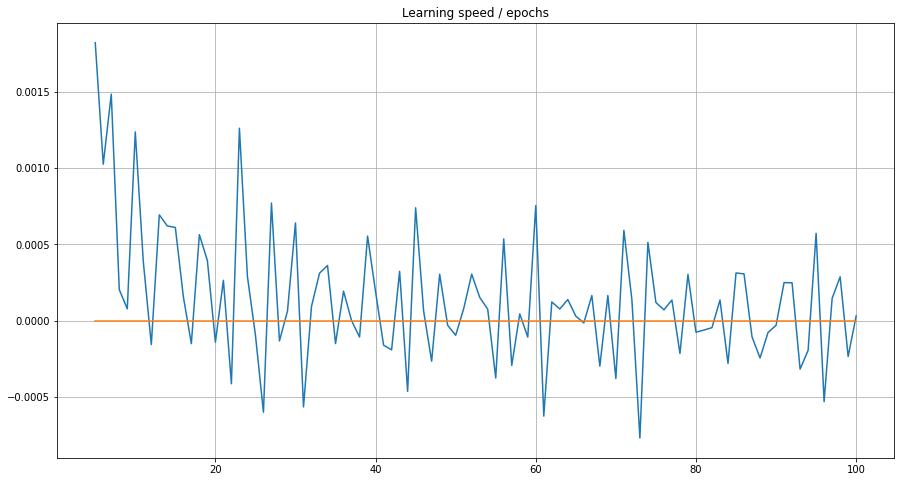

In [109]:
skip = 5
xi = range(skip, len(l_speed_history))
sns.lineplot(xi, l_speed_history[skip:])
sns.lineplot(xi, [0 for _ in xi]) 
plt.title('Learning speed / epochs')
plt.grid()
plt.gcf().set_size_inches(15,8)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


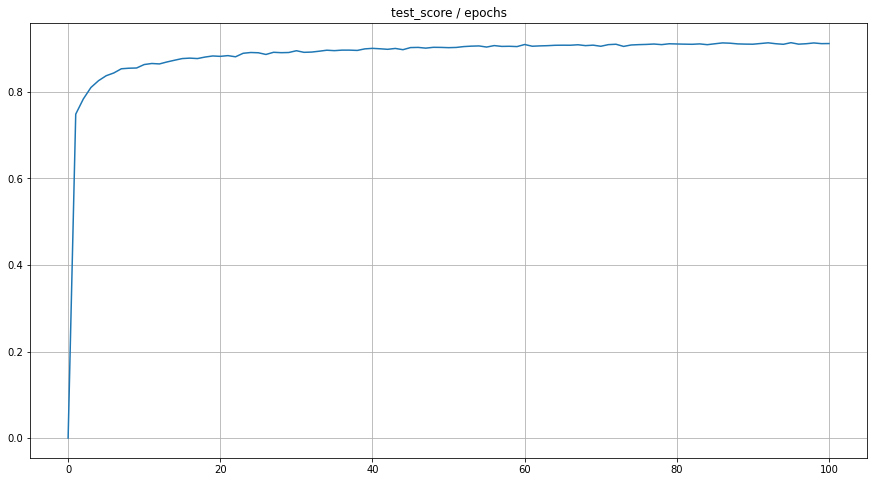

In [110]:
sns.lineplot(range(len(score_history)), score_history)
plt.title('test_score / epochs')
plt.grid()
plt.gcf().set_size_inches(15,8)